In [1]:
import sys

# import seaborn as sns
import numpy as np
from scipy import stats, integrate
import os
import matplotlib as mpl
import matplotlib.ticker as tk
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import re
from copy import deepcopy
from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import pandas as pd
import scipy.interpolate as interpolate
import json
import time
from astropy.time import Time
from mpl_toolkits import mplot3d
from copy import deepcopy
import random
import itertools
from scipy import interpolate

from joblib import dump, load

from sklearn import svm
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit, train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

plt.rcParams.update({'font.size': 12})
sys.path.append('/home/jtb34/GitHub/GACF/')
#sys.path.append('/home/jtb34/python27')
# print sys.path
from NGTS.NGTS_Field import return_field_from_object_directory, NGTSField
from NGTS.GACF_utils import TIME_CONVERSIONS
import NGTS.GACF_utils as utils

import NGTS.NGTS_Field as NGTS_Field

ROOT_DIR = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS'



/home/jtb34/GitHub/GACF/NGTS/NGTS_Field.py:11: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")
/home/jtb34/GitHub/GACF/NGTS/GACF_utils/ngtsio_utils.py:10: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")


In [2]:
XMATCH_LOCATION = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS/{}/cross_match/'
XMATCH_FILE_NAME = 'Uncut_Final_{}.fits'
def load_gaia_params(field):
    xmatch_path = os.path.join(XMATCH_LOCATION.format(field.fieldname),
                               XMATCH_FILE_NAME.format(field.fieldname))
    if not os.path.exists(xmatch_path):
        print xmatch_path, 'does not exist'
        return field

    with fits.open(xmatch_path) as gfits:
        for i, obj in enumerate(gfits[1].data['Sequence_number']):
            if obj in field.objects:
                field[obj].Gaia_Teff = gfits[1].data['Gaia_Teff'][i]
                field[obj].Gaia_Radius = gfits[1].data['Gaia_Radius'][i]
                field[obj].Gaia_Lum = gfits[1].data['Gaia_Lum'][i]
                field[obj].Gaia_Parallax = gfits[1].data['Gaia_Parallax'][i]
                field[obj].TWOMASS_Hmag = gfits[1].data['2MASS_Hmag'][i]
                field[obj].TWOMASS_Kmag = gfits[1].data['2MASS_Kmag'][i]
                field[obj].APASS_Vmag = gfits[1].data['APASS_Vmag'][i]
                field[obj].APASS_Bmag = gfits[1].data['APASS_Bmag'][i]
                field[obj].Gaia_Gmag = gfits[1].data['Gaia_Gmag'][i]
                field[obj].Gaia_RPmag = gfits[1].data['Gaia_RPmag'][i]
                field[obj].Gaia_BPmag = gfits[1].data['Gaia_BPmag'][i]
                field[obj].NGTS_I_3 = gfits[1].data['NGTS_I_3'][i]
                field[obj].BminusV = field[obj].APASS_Bmag - field[obj].APASS_Vmag
                field[obj].HminusK = field[obj].TWOMASS_Hmag - field[obj].TWOMASS_Kmag
                field[obj].GminusK = field[obj].Gaia_Gmag - field[obj].TWOMASS_Kmag
                field[obj].BPminusRP = field[obj].Gaia_BPmag - field[obj].Gaia_RPmag
#         print gfits[1].header

    return field

In [3]:
def find_fits_file(directory=None):
    if directory is None:
         directory = os.getcwd()
    string_pattern = r'^(?P<fieldname>\w+?[+-]\w+?)_\d+_[\w\-/,]+_(?P<test>\w+).fits$'
    pattern = re.compile(string_pattern)
    for f in os.listdir(directory):
        match = re.match(pattern, f)
        if match is not None:
            return f if directory is None else os.path.join(directory, f), match.group('fieldname'), match.group('test')
        
    raise IOError('File not found in directory {}'.format(directory))
    
# field.load_from_fits(fits_file, obj_ids=object_list, method='fitsio')

In [4]:
def split_phase(phase, data, timeseries=None, buff=0.9, nperiods=1):
    # returns list of lists of data & phases for complete periods (requires sorted phased timeseries)
    # buff => require this much phase coverage in first and last segments
    phases = []
    datas = []
    timeseriess = [] if timeseries is not None else None
    
    idx_changes = np.where(np.diff(phase) < 0)[0][::nperiods]
    use_first = True if (phase[0] < 1.0 - buff) else False
    use_last = True if (phase[-1] > buff) else False

    if use_first:
        phases.append(phase[:idx_changes[0]])
        datas.append(data[:idx_changes[0]])
        if timeseriess is not None:
            timeseriess.append(timeseries[:idx_changes[0]])
        
    for i, idx in enumerate(idx_changes[:-1]):
        phases.append(phase[idx+1:idx_changes[i+1]])
        datas.append(data[idx+1:idx_changes[i+1]])
        if timeseriess is not None:
            timeseriess.append(timeseries[idx+1:idx_changes[i+1]])
        
    if use_last or np.any(np.diff(phase[idx_changes[-1]+1:]) < 0):
        phases.append(phase[idx_changes[-1]:])
        datas.append(data[idx_changes[-1]:])
        if timeseriess is not None:
            timeseriess.append(timeseries[idx_changes[-1]:])
    if timeseriess is not None:    
        return phases, datas, timeseriess
    else:
        return phases, datas
#     save = False
#     phase_count = 0
#     for p, d in zip(phase, data):
        

In [5]:
pdics = {}
fieldnames = []
field_pattern = re.compile(r'^NG\d+[+|-]\d+$')

for f in os.listdir(ROOT_DIR):
    if re.match(field_pattern, f):
        fieldnames.append(f)
print "Found {} fields".format(len(fieldnames))
# print fieldnames
# fieldnames = fieldnames[1:5]
# fieldnames = ['NG2346-3633']

for field in fieldnames:
    field_dir = os.path.join(ROOT_DIR, field)
    pdic_filename = 'NGTS_Field_{}_pdic.json'.format(field)
    if pdic_filename in os.listdir(field_dir):
        with open(os.path.join(*[ROOT_DIR, field, pdic_filename])) as f:
            pdics[field] = json.load(f)
            pdics[field] = {int(k):v for k,v in pdics[field].iteritems()}

Found 115 fields


In [6]:
for k,v in pdics.iteritems():
    print k, len(v)

NG0458-3056 73
NG0535-0523 770
NG0518-3633 84
NG1429-3056 109
NG2028-2518 94
NG0523-0104 333
NG0532-3633 80
NG1114-3056 104
NG1416-2518 58
NG0450-3633 60
NG0914-1652 125
NG0613-3633 143
NG1112-3345 128
NG0304-1115 59
NG0504-3633 80
NG2346-3633 41
NG1200-3633 126
NG0931-1941 94
NG0537-3056 74
NG0511-3056 76
NG0448-3922 70
NG0531-0826 207
NG2142+0826 95
NG0445-3056 61
NG2126-1652 65
NG0612-2518 171
NG0618-6441 260
NG0549-3345 127
NG0004-2950 115
NG0409-1941 68
NG0603-3056 148
NG0456-3345 82
NG0522-2518 112
NG0603-3345 137
NG2331-3922 45
NG0509-3345 77
NG0348-3345 56
NG0524-3056 91
NG0502-3922 70
NG0616-3345 715
NG0353-3056 59


In [7]:
FIELDNAMES = ['NG0304-1115', 'NG1416-2518', 'NG2142+0826']
# FIELDNAME = 'NG0304-1115'
# FIELDNAME = 'NG1416-2518'
# FIELDNAME = 'NG2142+0826'
# fits_file, _, _ = find_fits_file(os.path.join(ROOT_DIR, FIELDNAME))
# with fits.open(fits_file) as ff:
#     obj_ids = np.array(map(int, ff['CATALOGUE'].data['OBJ_ID']))
# print '{} objects found'.format(len(obj_ids))

In [8]:
# first_obj = np.random.randint(0, len(obj_ids)-1)
# long_periods = {FIELDNAME: list(obj_ids[np.arange(first_obj, min(first_obj + 100, len(obj_ids)-1), 1)])}
long_periods = {}
for fieldname in FIELDNAMES:
    long_periods[fieldname] = pdics[fieldname].keys()
print long_periods

{'NG0304-1115': [9728, 10496, 11781, 17034, 10891, 13836, 5645, 6286, 4241, 3346, 15380, 15125, 17838, 18901, 3228, 6557, 2160, 36, 11302, 1959, 18728, 41, 6830, 14512, 2098, 15337, 15028, 2744, 15675, 6332, 2880, 12609, 73, 8906, 8780, 13133, 3664, 1105, 10581, 5518, 18137, 5210, 13787, 5214, 18789, 7650, 3788, 14821, 15590, 4329, 12394, 14059, 3181, 15343, 624, 11506, 9591, 4628, 18687], 'NG1416-2518': [47126, 36391, 20107, 18189, 273, 38339, 44053, 278, 922, 27035, 54816, 13040, 32932, 27301, 33830, 561, 42923, 16940, 19879, 24112, 48584, 11379, 42292, 30517, 39225, 37435, 22588, 17726, 6719, 41283, 2117, 46920, 17610, 17357, 13012, 37205, 45910, 13528, 20955, 50397, 38622, 11430, 35168, 356, 40165, 34152, 22506, 1319, 26861, 9200, 242, 2675, 30142, 8952, 45051, 36989, 27646, 54974], 'NG2142+0826': [26113, 32259, 29703, 17419, 18956, 11791, 12310, 3613, 26662, 16935, 16426, 7217, 7738, 5700, 8780, 26808, 6228, 20566, 23137, 31335, 19047, 21615, 10600, 13429, 631, 18560, 6276, 3209, 

In [12]:
reload(NGTS_Field)

fields = {}
# gfields = {}
good_objs = 0
for fieldname, objs in long_periods.iteritems():
    objs = [31335,9559,10600,18051, 13258,1456,5397,2442,12785]
    if len(objs) < 1:
        continue
#     objs = np.array(objs)[np.random.randint(0, len(objs)-1, 10)].tolist()
    if fieldname not in ['NG2142+0826']:
        continue
# for fieldname, objs in {'NG0004-2950': [2048]}.iteritems():
    t1 = time.time()
    field = NGTS_Field.return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', 
                                               include_empty_objects=True, silent=True, obj_ids=objs)
#     field = NGTSField(fieldname=fieldname, test='CYCLE1807', object_list=pdics[fieldname].keys())
#     t2 = time.time()
#     field = load_gaia_params(field)
#     t3 = time.time()
#     for obj in field:
#         try:
#             obj.cleaned_refined_periods = pdics[fieldname][obj.obj]
#         except KeyError:
#             obj.cleaned_refined_periods = None
    
#     gfield = NGTSField(fieldname=fieldname, test='CYCLE1807', object_list=obj_lists[fieldname])
#     gfield = load_gaia_params(gfield)
    t4 = time.time()
    fits_file, _, _ = find_fits_file(os.path.join(ROOT_DIR, fieldname))
    field.load_from_fits(fits_file, obj_ids=objs, method='fitsio', sparse_ids=True)
    t5 = time.time()
#     new_moon_epoch = field.get_new_moon_epoch()
    fields[fieldname] = field
    print 'Field {} loaded'.format(field)

matched 9228 of 9239 files. Loaded 9 objects
Field NGTS Field NG2142+0826 loaded


In [13]:
fields

{'NG2142+0826': NGTS Field NG2142+0826}

In [15]:
new_moon_epoch = 944.9544317343119

In [16]:
ratios = {}
for fieldname, field in fields.iteritems():
    ratios[fieldname] = []
    n = 0
    for obj in field:
#         if obj.obj not in cool_objs:
#             continue
#         if n < 5:
#             n += 1
#             continue
#         if n > 10:
#             break
#         print '****** {} ******'.format(obj)
#         print obj.periods
#         print obj.cleaned_refined_periods
#         print obj.peak_size
        obj.nsig2keep = 5
        
        t = obj.timeseries_binned
        f = obj.flux_binned
#         p = pdics[fieldname][obj.obj][0]
        try:
            p = obj.periods[0]
            if p < 1.0:
#                 field.objects[obj.obj] = None
                continue
#             if len(obj.periods > 10):
#                 field.objects[obj.obj] = None
#                 continue
        except Exception:
#             field.objects[obj.obj] = None
            continue
        phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
        binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
        tref = (Time(Time(np.median(t) + utils.NGTS_EPOCH, format='jd').to_datetime()
                     .replace(hour=12, minute=0, second=0)).jd - utils.NGTS_EPOCH)
        pref = np.mod(tref - new_moon_epoch, p) / p 
        
        spread1 = utils.split_and_compute_percentile_per_specified_time_period(t, f, tref, 1, nsigma=3)
        spread2 = utils.split_and_compute_percentile_per_specified_time_period(t, f, tref, p)
        
        signal_spread_ratio = spread2 / spread1
#         print 'Signal spread {} times larger than daily spread'.format(signal_spread_ratio)
        
        spread1_phase = utils.split_and_compute_percentile_per_specified_time_period(phase_app, data_app, 0, 0.05, nsigma=3)
        spread2_phase = utils.split_and_compute_percentile_per_specified_time_period(phase_app, data_app, 0, 1)
        
        phase_spread_ratio = spread2_phase / spread1_phase
#         print 'Phased signal spread {} times larger than 0.05 phase spread'.format(phase_spread_ratio)

        if p >= 15:
            nperiods = 1
        elif 5 < p < 15:
            nperiods = 2
        elif 1 < p < 5:
            nperiods = 3
        else:
            nperiods = 1
        
        phases, datas, timeseriess = split_phase(phase_app, data_app, obj.timeseries_binned, nperiods=nperiods)
        
        spread_ratios = []
        for pp, fp in zip(phases, datas):
            try:
                spread1_phase = utils.split_and_compute_percentile_per_specified_time_period(pp, fp, 0, 0.05, nsigma=3)
                spread2_phase = utils.split_and_compute_percentile_per_specified_time_period(pp, fp, 0, 1)
            except ValueError:
                pp_ratio = np.nan
            else:
                pp_ratio = spread2_phase / spread1_phase
            spread_ratios.append(pp_ratio) if pp_ratio != np.inf else spread_ratios.append(np.nan)
#         print spread_ratios
#         print np.nanpercentile(spread_ratios, [10., 50., 90.])
        phased_signal_spread_ratio =  np.nanmean(spread_ratios)
#         print 'Phased signal spread per period {} times larger than 0.05 phase spread'.format(phased_signal_spread_ratio)
        
    
        ratios[fieldname].append((obj.obj, signal_spread_ratio, phase_spread_ratio, phased_signal_spread_ratio))
        
#         if signal_spread_ratio > 2.5 and phase_spread_ratio > 1.4 and :
#             print "###### OBJECT OK ######"
#             good_objs += 1
#         else:
# #             pass
#             print 'Rejected object on signal strength'
        
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5))
#         ax1.scatter(t-t[0], f, s=0.1)
#         ax1.set_title('Data'.format(p))
#         ax2.scatter(phase_app, data_app, s=0.1)
#         ax2.scatter(binned_phase_app, binned_data_app, s=5, c='r')
#         ax2.axvline(x=0, lw=0.1, c='k', ls='--')
#         ax2.axvline(x=1, lw=0.1, c='k', ls='--')
#         ax2.set_title('Data phase folded on {} day period'.format(p))
#         fig.tight_layout()
#         plt.show()

        n += 1
    

In [17]:
print '\n'.join(map(str,sorted(ratios[fieldname], key=lambda x: np.sum([x[1], x[2], x[3]]), reverse=True)))

(10600, 4.451550172821868, 1.7244935793327223, 5.675765432756827)
(31335, 4.361251910464508, 2.1263453988826146, 5.2321762200446065)
(9559, 4.902864485306464, 2.17517435592809, 4.43372249239816)
(13258, 1.7926633706274835, 1.181084777423802, 2.0580621430674246)
(18051, 1.6453297487017902, 1.1355596630233957, 1.759895325126754)
(5397, 1.4860037082560924, 1.2789405084251289, 1.5408752347748946)
(2442, 1.4859595686708031, 1.1690238691586077, 1.6128761984701103)
(12785, 1.4016529972034393, 1.114211831136753, 1.6269210233165199)
(1456, 1.5039516016528338, 1.0906419344287155, 1.2037465101968845)


In [14]:
with open('eyeballed_objs.json', 'r') as f:
    results = json.load(f)
for fieldname, value in results.iteritems():
    results[fieldname]= {int(k):v for k,v in value.iteritems()}
dic_to_save = {}
for fieldname in FIELDNAMES:
    dic_to_save[fieldname] = {}
    for v in ratios[fieldname]:
        obj_id = v[0]
        obj_ratios = [v[1], v[2], v[3]]
        try:
            yval = results[fieldname][obj_id]
#             print '{}_{} ok'.format(fieldname, obj_id)
        except KeyError:
#             print '{}_{} not found'.format(fieldname, obj_id)
            yval = None
            continue
        obj_dic = {'score': yval,
                   'ratios': obj_ratios}
        dic_to_save[fieldname][obj_id] = obj_dic
    print 'Field {} has {} objects'.format(fieldname, len(dic_to_save[fieldname]))

KeyError: 'NG0304-1115'

In [15]:

ratios_from_dic = list(itertools.chain.from_iterable([obj_data.iteritems() for obj_data in dic_to_save.values()]))
# ratios_from_dic = [v[1]['ratios'] for v in ratios_from_dic]
obj_ids = [v[0] for v in ratios_from_dic]
obj_ids

[14338,
 8196,
 12304,
 2734,
 8215,
 14364,
 12317,
 16423,
 18474,
 14379,
 18481,
 2098,
 8247,
 8260,
 12357,
 14411,
 16462,
 12367,
 2744,
 10323,
 85,
 12389,
 102,
 12394,
 16491,
 14448,
 16500,
 118,
 18551,
 4216,
 12415,
 6273,
 10375,
 6286,
 4241,
 4248,
 6299,
 12461,
 175,
 14512,
 14516,
 16570,
 8379,
 6332,
 8906,
 192,
 8386,
 4294,
 9591,
 12496,
 8402,
 14551,
 4315,
 16609,
 4327,
 4329,
 6379,
 4333,
 8433,
 18687,
 10496,
 2091,
 16645,
 2311,
 12556,
 272,
 12564,
 4373,
 291,
 4389,
 18728,
 8490,
 14636,
 14645,
 10559,
 12609,
 337,
 10581,
 12630,
 14700,
 16752,
 4475,
 18814,
 6542,
 2447,
 8601,
 10650,
 8603,
 6557,
 18849,
 18867,
 10684,
 18885,
 4559,
 18901,
 10711,
 6617,
 8671,
 14821,
 18918,
 16877,
 8693,
 2550,
 10768,
 18963,
 4628,
 2604,
 10808,
 16964,
 15295,
 2630,
 4683,
 8780,
 10838,
 8802,
 16995,
 19047,
 624,
 12913,
 4728,
 2683,
 8299,
 17034,
 10891,
 8858,
 19099,
 112,
 17067,
 6830,
 19121,
 6835,
 8888,
 19131,
 8896,
 4803

In [29]:
all_results = np.array(list(itertools.chain.from_iterable([r.values() for r in results.values()])))
print len(all_results)
print len(np.where(all_results == 1.0)[0])
print len(np.where(all_results == 0.0)[0])
print len(np.where(all_results == 0.5)[0])

1165
232
830
103


In [28]:
# with open('svm_training_data.json', 'w') as jsf:
#     json.dump(dic_to_save, jsf)

In [150]:
sums = [(r[0], r[1] + r[2] + r[3]) for r in ratios]
sums = [s for s in sums if np.isfinite(s[1])]
fig, ax = plt.subplots(figsize=(10,10))
plt.hist([s[1] for s in sums], bins=32)
plt.show()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [40]:
for obj_id, ra, rb, rc in ratios:
    if obj_id == 2045:
        obj = field[obj_id]
        print '*******'
        print obj
        print 'Prediction: {}'.format(clf.predict([[ra, rb, rc]]))
        t = obj.timeseries_binned
        f = obj.flux_binned
        p = obj.periods[0]
        phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
        binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5))
        ax1.scatter(t-t[0], f, s=0.1)
        ax1.set_title('Data'.format(p))
        ax2.scatter(binned_phase_app, binned_data_app, s=5, c='r')
        ax2.axvline(x=0, lw=0.1, c='k', ls='--')
        ax2.axvline(x=1, lw=0.1, c='k', ls='--')
        ax2.set_title('Data phase folded on {} day period'.format(p))
        fig.tight_layout()
        plt.show()

ValueError: too many values to unpack

In [27]:
spread1_phase = utils.split_and_compute_percentile_per_specified_time_period(phase_app, data_app, 0, 0.05, nsigma=3)
spread2_phase = utils.split_and_compute_percentile_per_specified_time_period(phase_app, data_app, 0, 1)

phase_spread_ratio = spread2_phase / spread1_phase
print 'Phased signal spread {} times larger than 0.05 phase spread'.format(phase_spread_ratio)

phases, datas, timeseriess = split_phase(phase_app, data_app, obj.timeseries_binned)
        
spread_ratios = []
for pp, fp in zip(phases, datas):
    try:
        spread1_phase = utils.split_and_compute_percentile_per_specified_time_period(pp, fp, 0, 0.05, nsigma=3)
        spread2_phase = utils.split_and_compute_percentile_per_specified_time_period(pp, fp, 0, 1)
    except ValueError:
        phase_spread_ratio = np.nan
    else:
        phase_spread_ratio = spread2_phase / spread1_phase
    spread_ratios.append(phase_spread_ratio) if phase_spread_ratio != np.inf else spread_ratios.append(np.nan)
#         print spread_ratios
#         print np.nanpercentile(spread_ratios, [10., 50., 90.])
phased_signal_spread_ratio =  np.nanmean(spread_ratios)
print 'Phased signal spread per period {} times larger than 0.05 phase spread'.format(phased_signal_spread_ratio)

Phased signal spread 3.46913459916 times larger than 0.05 phase spread
Phased signal spread per period 10.7532859226 times larger than 0.05 phase spread


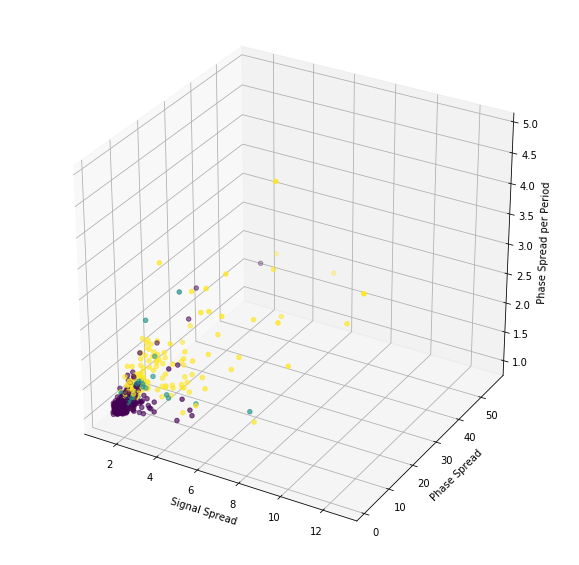

In [78]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D([r[1] for r in ratios], [r[3] for r in ratios], [r[2] for r in ratios], c=colors, cmap='viridis')
ax.set_xlabel('Signal Spread')
ax.set_ylabel('Phase Spread')
ax.set_zlabel('Phase Spread per Period')
plt.show()

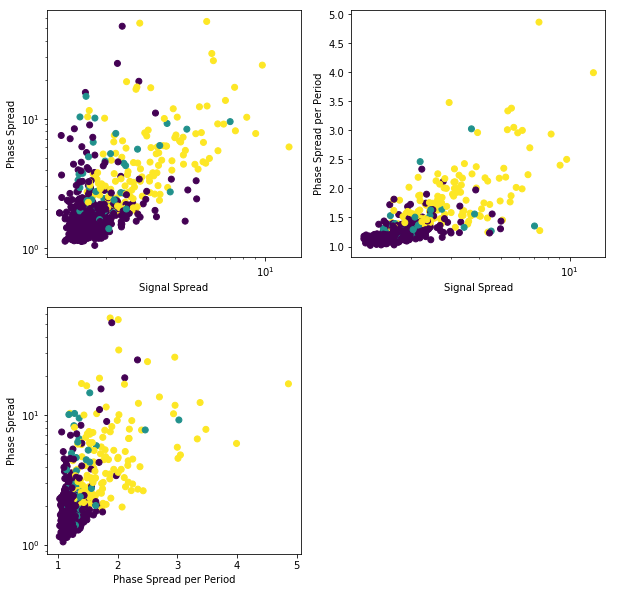

In [77]:
o, a, b, c = [r[0] for r in ratios], [r[1] for r in ratios], [r[3] for r in ratios], [r[2] for r in ratios]

colors = [good_objs_bak[ob] for ob in o]

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[1,1].axis('off')

axs[0,0].scatter(a, b, c=colors, cmap='viridis')
axs[0,0].set_xlabel('Signal Spread')
axs[0,0].set_xscale('log')
axs[0,0].set_ylabel('Phase Spread')
axs[0,0].set_yscale('log')

axs[1,0].scatter(c, b, c=colors, cmap='viridis')
axs[1,0].set_xlabel('Phase Spread per Period')
axs[1,0].set_ylabel('Phase Spread')
axs[1,0].set_yscale('log')

axs[0,1].scatter(a, c, c=colors, cmap='viridis')
axs[0,1].set_xlabel('Signal Spread')
axs[0,1].set_xscale('log')
axs[0,1].set_ylabel('Phase Spread per Period')

plt.show()

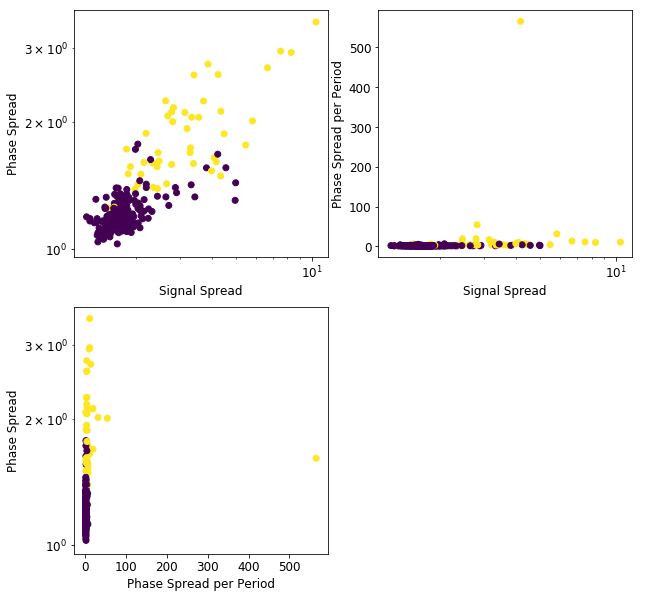

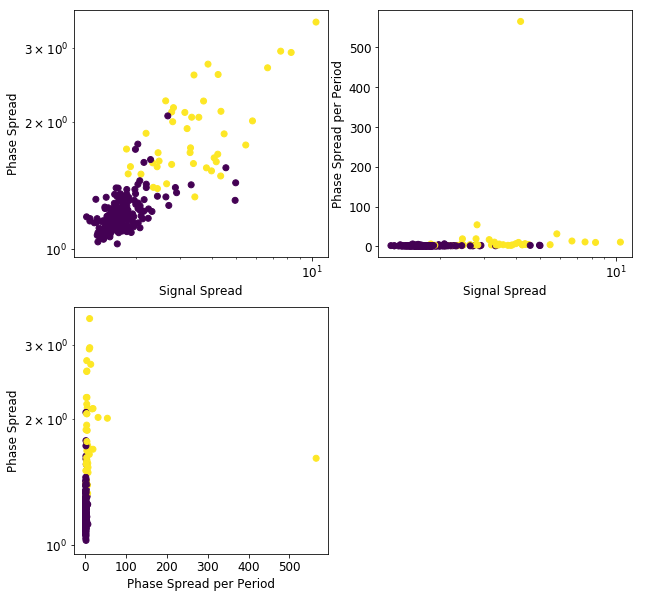

In [39]:
a, b, c = [r[0] for r in X_test], [r[1] for r in X_test], [r[2] for r in X_test]

colors = y_test

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[1,1].axis('off')

axs[0,0].scatter(a, b, c=colors, cmap='viridis')
axs[0,0].set_xlabel('Signal Spread')
axs[0,0].set_xscale('log')
axs[0,0].set_ylabel('Phase Spread')
axs[0,0].set_yscale('log')

axs[1,0].scatter(c, b, c=colors, cmap='viridis')
axs[1,0].set_xlabel('Phase Spread per Period')
axs[1,0].set_ylabel('Phase Spread')
axs[1,0].set_yscale('log')

axs[0,1].scatter(a, c, c=colors, cmap='viridis')
axs[0,1].set_xlabel('Signal Spread')
axs[0,1].set_xscale('log')
axs[0,1].set_ylabel('Phase Spread per Period')

plt.show()

colors = clf.predict(X_test)

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[1,1].axis('off')

axs[0,0].scatter(a, b, c=colors, cmap='viridis')
axs[0,0].set_xlabel('Signal Spread')
axs[0,0].set_xscale('log')
axs[0,0].set_ylabel('Phase Spread')
axs[0,0].set_yscale('log')

axs[1,0].scatter(c, b, c=colors, cmap='viridis')
axs[1,0].set_xlabel('Phase Spread per Period')
axs[1,0].set_ylabel('Phase Spread')
axs[1,0].set_yscale('log')

axs[0,1].scatter(a, c, c=colors, cmap='viridis')
axs[0,1].set_xlabel('Signal Spread')
axs[0,1].set_xscale('log')
axs[0,1].set_ylabel('Phase Spread per Period')

plt.show()

Object 1 of 9
NGTS Object NG2142+0826_18051 (CYCLE1807)


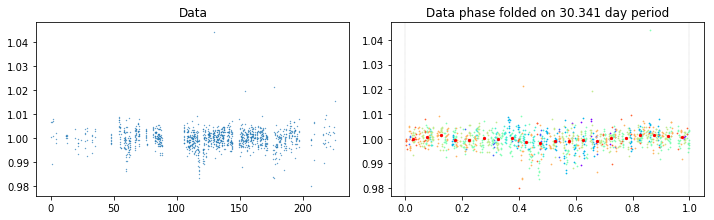

SEJveChjaGlsZHJlbj0oQnV0dG9uKGRlc2NyaXB0aW9uPXUnR29vZCEnLCBzdHlsZT1CdXR0b25TdHlsZShidXR0b25fY29sb3I9J2dyZWVuJykpLCBCdXR0b24oZGVzY3JpcHRpb249dSdCYWTigKY=


In [21]:
import ipywidgets as widgets
from IPython.display import display, clear_output
good_objs = {}
objs = field.objects.keys()

buttony = widgets.Button(description="Good!")
buttonm = widgets.Button(description="Maybe?")
buttonn = widgets.Button(description="Bad!")
buttone = widgets.Button(description="Finish")

buttony.style.button_color = 'green'
buttonm.style.button_color = 'yellow'
buttonn.style.button_color = 'red'
buttone.style.button_color = 'gray'

bb = widgets.HBox([buttony, buttonn, buttonm, buttone])

button_press = None
def on_ybutton_clicked(b):
    button_press = 1.0
    next_plot(v=button_press)
#     clear_output()

def on_nbutton_clicked(b):
    button_press = 0.0
    next_plot(v=button_press)
#     clear_output()

def on_mbutton_clicked(b):
    button_press = 0.5
    next_plot(v=button_press)
#     clear_output()

def on_ebutton_clicked(b):
    next_plot(exit=True)
#     clear_output()

buttony.on_click(on_ybutton_clicked)
buttonm.on_click(on_mbutton_clicked)
buttonn.on_click(on_nbutton_clicked)
buttone.on_click(on_ebutton_clicked)

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

i = 0

def next_plot(v=None, first=False, exit=False):
    global button_press
    global i
    clear_output()
    if objs[i] in good_objs_bak:
#         good_objs[i] = good_objs_bak[objs[i]]
        print 'Previous result was:', good_objs_bak[objs[i]] 
#         next_plot(good_objs_bak[objs[i-1]])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
    fig.tight_layout()
    if not first:
        good_objs[objs[i-1]] = v
    try:
        obj = field[objs[i]]
    except IndexError:
        print 'nope'
        return
    else:
#         ax1.clear()
#         ax2.clear()
        print 'Object {} of {}'.format(i+1, field.num_objects)
        print obj
        t = obj.timeseries_binned
        f = obj.flux_binned
        p = obj.cleaned_refined_periods[0]
        phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
        binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)

        ax1.scatter(t-t[0], f, s=0.1)
        ax1.set_title('Data'.format(p))
        ndata = len(phase_app)
        idx = [i2 for i2 in range(1,ndata) if phase_app[i2]<phase_app[i2-1] ]
        idx.append(ndata-1)
        nidx = len(idx)
        colours = mpl.cm.rainbow(np.r_[0:1:nidx*1j])
        phases, fs = [], []
        j=0
        for k,i2 in enumerate(idx):
            phases.append( np.array(phase_app[j:i2]) )
            fs.append( np.array(f[j:i2]) )
            ax2.scatter(phases[k], fs[k], marker='o', s=0.5, c=colours[k])
            j=i2
        ax2.scatter(binned_phase_app, binned_data_app, s=5, c='r')
        ax2.axvline(x=0, lw=0.1, c='k', ls='--')
        ax2.axvline(x=1, lw=0.1, c='k', ls='--')
        ax2.set_title('Data phase folded on {} day period'.format(p))
#         prange = max(binned_data_app) - min(binned_data_app)
#         ax2.set_ylim([np.median(data_app)-2*prange, np.median(data_app)+2*prange])
        plt.show()
        if exit:
            return
        else:
            display(bb)
            i += 1

next_plot(first=True)
# while i < field.num_objects:

In [16]:
with open('eyeballed_objs.json', 'r') as f:
    results = json.load(f)
for fieldname, value in results.iteritems():
    results[fieldname]= {int(k):v for k,v in value.iteritems()}
results

{u'NG0304-1115': {85: 1.0,
  102: 0.0,
  112: 0.0,
  118: 1.0,
  175: 0.0,
  192: 0.5,
  272: 0.0,
  291: 1.0,
  309: 0.0,
  337: 0.0,
  598: 0.0,
  624: 1.0,
  710: 0.0,
  714: 1.0,
  808: 0.0,
  862: 0.0,
  927: 0.5,
  950: 0.0,
  1020: 0.0,
  1045: 0.5,
  1105: 0.5,
  1185: 1.0,
  1388: 0.0,
  1405: 0.0,
  1447: 0.0,
  1490: 0.0,
  1593: 0.0,
  1615: 0.0,
  1697: 0.0,
  1709: 0.0,
  1724: 0.0,
  1762: 0.0,
  1931: 0.0,
  1959: 0.5,
  2091: 0.0,
  2098: 1.0,
  2160: 1.0,
  2311: 0.5,
  2447: 0.0,
  2550: 0.5,
  2604: 0.0,
  2630: 0.5,
  2683: 1.0,
  2734: 0.0,
  2744: 1.0,
  2880: 1.0,
  3188: 0.0,
  3228: 1.0,
  3335: 0.5,
  3346: 1.0,
  3476: 0.0,
  3490: 0.0,
  3577: 0.0,
  3664: 1.0,
  3699: 0.0,
  3702: 0.0,
  3747: 0.5,
  3765: 0.0,
  3788: 1.0,
  3842: 1.0,
  3872: 0.0,
  3944: 0.0,
  3962: 0.0,
  4216: 0.5,
  4241: 1.0,
  4248: 1.0,
  4294: 0.0,
  4315: 0.0,
  4327: 0.0,
  4329: 1.0,
  4333: 1.0,
  4373: 0.0,
  4389: 0.0,
  4475: 0.0,
  4559: 0.5,
  4628: 1.0,
  4683: 0.5,
  

In [20]:
# good_objs_bak = good_objs = results[fieldname]
good_objs_bak = good_objs = []

In [70]:

good_objs_bak = deepcopy(good_objs)

In [21]:
len([g for g in good_objs.values() if g == 1.0])

88

In [79]:
good_objs_bak

{76: 0.0,
 86: 0.0,
 87: 0.0,
 107: 1.0,
 143: 0.0,
 150: 0.0,
 304: 0.0,
 326: 1.0,
 336: 0.0,
 381: 0.0,
 403: 0.0,
 417: 0.0,
 441: 0.0,
 450: 1.0,
 479: 0.0,
 581: 0.0,
 631: 1.0,
 666: 0.0,
 685: 0.0,
 778: 0.0,
 810: 1.0,
 882: 0.0,
 893: 0.0,
 910: 1.0,
 940: 0.0,
 974: 0.0,
 986: 0.0,
 1039: 1.0,
 1055: 0.0,
 1059: 0.0,
 1102: 0.0,
 1127: 0.0,
 1147: 0.0,
 1185: 0.0,
 1186: 0.0,
 1225: 0.0,
 1250: 0.0,
 1298: 0.0,
 1376: 1.0,
 1450: 0.0,
 1451: 0.0,
 1456: 0.0,
 1504: 0.0,
 1663: 0.0,
 1759: 0.0,
 1777: 0.0,
 1812: 0.0,
 1820: 0.0,
 1868: 0.0,
 1881: 0.0,
 1917: 0.0,
 2045: 0.0,
 2051: 0.0,
 2064: 0.0,
 2098: 0.0,
 2099: 0.0,
 2180: 0.0,
 2198: 0.0,
 2249: 0.0,
 2259: 0.0,
 2362: 0.0,
 2437: 0.0,
 2443: 0.0,
 2562: 0.0,
 2593: 0.5,
 2599: 0.0,
 2730: 0.0,
 2771: 0.0,
 2773: 0.0,
 2790: 0.0,
 2816: 0.0,
 2818: 0.0,
 2822: 0.0,
 2954: 0.0,
 2968: 0.0,
 2987: 0.0,
 3017: 0.0,
 3081: 0.0,
 3117: 0.0,
 3209: 1.0,
 3230: 0.0,
 3273: 0.0,
 3287: 0.0,
 3290: 0.0,
 3292: 0.0,
 3319: 0.0

In [156]:
X = np.array([np.array([d[1],d[2],d[3]]) for d in ratios])
X[:5]

array([[ 1.55330844,  1.07851172,  1.12441022],
       [ 1.55014317,  1.10387494,  1.57283839],
       [ 1.73210641,  1.08935071,  1.72010684],
       [ 1.59005266,  1.23339506,  1.49791311],
       [ 2.77773283,  2.11809693, 19.38096802]])

In [157]:
y = np.array([int(good_objs[d[0]]) for d in ratios])
# y = np.array([int(good_objs[d[0]]*2) for d in ratios])
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [158]:
clf.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [159]:
clf.predict([[10,10,10],[2,2,2],[1,1,1]])

array([1, 0, 0])

In [160]:
y_pred = clf.decision_function(X)

In [161]:
float(np.count_nonzero(y == y_pred)) / float(len(y))

0.0

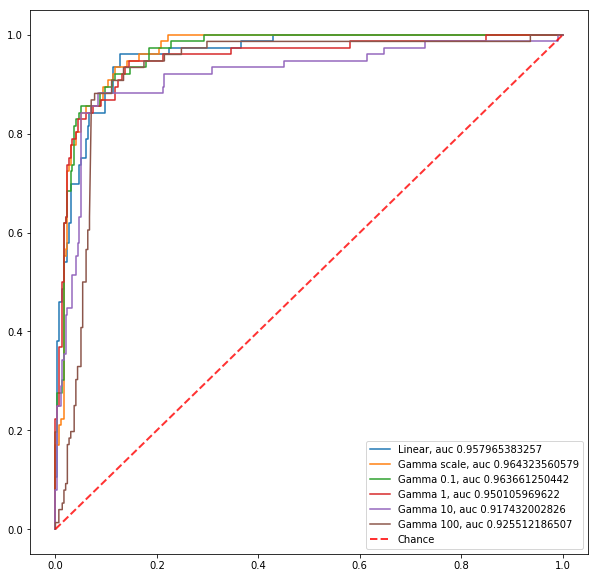

In [187]:



fig, ax = plt.subplots(figsize=(10, 10))
clf = svm.SVC(kernel='linear')
clf.fit(X,y)
y_pred = clf.decision_function(X_test)
average_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ax.plot(fpr, tpr, label='Linear, auc {}'.format(auc))
for g in ['scale', 0.1, 1, 10, 100]:
    clf = svm.SVC(kernel='rbf', gamma=g)
    clf.fit(X,y)
    y_pred = clf.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    ax.plot(fpr, tpr, label='Gamma {}, auc {}'.format(g, auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
ax.legend()
plt.show()

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
# step_kwargs = ({'step': 'post'})
# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
#           average_precision))
# plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plt.show()

In [186]:
X_test = np.array([np.array([d[1],d[2],d[3]]) for d in ratios[FIELDNAME]])
good_objs_test = results[FIELDNAME]
y_test = np.array([int(good_objs_test[d[0]]) for d in ratios[FIELDNAME]])

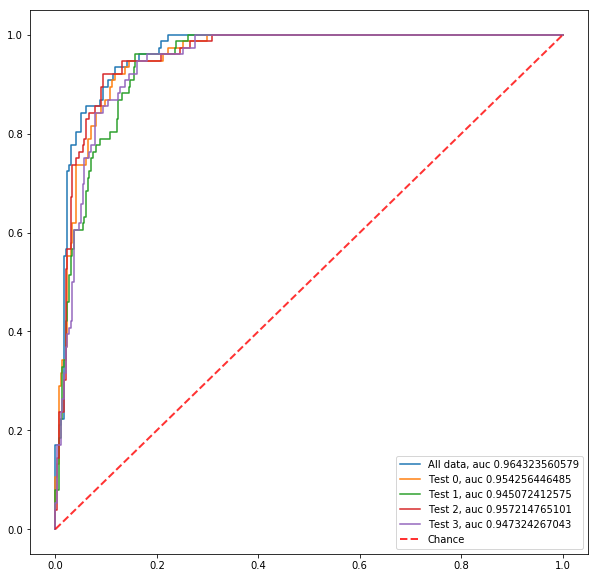

In [190]:
fig, ax = plt.subplots(figsize=(10, 10))
clf = svm.SVC(kernel='rbf', gamma='scale')
clf.fit(X,y)
y_pred = clf.decision_function(X_test)
average_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ax.plot(fpr, tpr, label='All data, auc {}'.format(auc))
for g in range(4):
    idxs = np.random.randint(0, len(X)-1, 100)
    clf = svm.SVC(kernel='rbf', gamma='scale')
    clf.fit(X[idxs],y[idxs])
    y_pred = clf.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    ax.plot(fpr, tpr, label='Test {}, auc {}'.format(g, auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
ax.legend()
plt.show()

In [81]:
# check results are the same as the pdic objects
for fieldname in FIELDNAMES:
    eyeballing_objs = set(results[fieldname].keys())
    pdic_objs = set(pdics[fieldname].keys())
    print 'Field {}, eyeballed {}, periods {}'.format(fieldname, len(eyeballing_objs), len(pdic_objs))

Field NG0304-1115, eyeballed 374, periods 374
Field NG1416-2518, eyeballed 103, periods 103
Field NG2142+0826, eyeballed 688, periods 688


In [82]:
[len(r) for r in results.values()]

[374, 103, 688]

In [6]:
# load training data
with open('svm_training_data.json', 'r') as jsf:
    training_data_dict = json.load(jsf)
print '{} fields found, with {} objects'.format(len(training_data_dict), np.sum([len(v) for v in training_data_dict.values()]))

3 fields found, with 1165 objects


In [7]:
all_data = list(itertools.chain.from_iterable([obj_data.iteritems() for obj_data in training_data_dict.values()]))
ratios_from_dic = [v[1]['ratios'] for v in all_data]
outcomes_from_dic = [v[1]['score'] for v in all_data]
obj_ids = [int(v[0]) for v in all_data]

In [8]:
# y_data_set = np.array([int(round(a)) for a in outcomes_from_dic]) # maybe ==> 1
y_data_set = np.array([int(a) for a in outcomes_from_dic]) # maybe ==> 0
weights = np.array([1 if a == 0.5 else 5 for a in outcomes_from_dic])
print np.array(outcomes_from_dic)
print y_data_set
print weights

[0.5 0.5 0.  ... 0.  0.  1. ]
[0 0 0 ... 0 0 1]
[1 1 5 ... 5 5 5]


In [9]:
X_total = np.array(ratios_from_dic)
y_total = np.array(y_data_set)
W_total = np.array(weights)

In [10]:

# fig, ax = plt.subplots(figsize=(10, 10))
# # try 5 different training/test splits
# svms = []
# n_points = len(y_data_set)
# # n_points=5
# training_split = 0.9
# n_points_training = int(n_points * training_split)
# n_points_test = n_points - n_points_training
# print 'Using {} points for training, {} for testing out of {}'.format(n_points_training, n_points_test, n_points)
# for i in range(10):
#     idx_training = random.sample(xrange(0, n_points), n_points_training)
#     idx_test = [n for n in xrange(0, n_points) if n not in idx_training]
# #     print len(set(idx_training).intersection(set(idx_test)))
# #     print sorted(idx_training)
# #     print sorted(idx_test)
# #     print len(idx_training), len(idx_test), len(idx_training) + len(idx_test)

#     X_train = np.array(ratios_from_dic)[idx_training]
#     y_train = np.array(y_data_set)[idx_training]
#     w_train = np.array(weights)[idx_training]
    
#     X_test = np.array(ratios_from_dic)[idx_test]
#     y_test = np.array(y_data_set)[idx_test]
#     w_test = np.array(weights)[idx_test]
    
#     clf = svm.SVC(kernel='rbf', gamma='scale')
#     clf.fit(X_train,y_train, sample_weight=w_train)
    
#     y_pred = clf.decision_function(X_test)
#     average_precision = average_precision_score(y_test, y_pred)
#     precision, recall, _ = precision_recall_curve(y_test, y_pred)
#     auc = roc_auc_score(y_test, y_pred)
#     fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
#     ax.plot(fpr, tpr, label='Test {}, auc {}'.format(i, auc))
    
# ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#              label='Chance', alpha=.8)
# ax.legend()
# plt.show()

In [11]:
# a, b, c = [r[0] for r in X_test], [r[1] for r in X_test], [r[2] for r in X_test]

# alpha = np.array(map(float, w_test)) / float(max(w_test))
# colors = np.asarray([(0, v, 0, al) for al, v in zip(alpha, y_test)])

# fig, axs = plt.subplots(2, 2, figsize=(10,10))
# axs[1,1].axis('off')
# axs[0,0].scatter(a, b, c=colors, cmap='viridis')
# axs[0,0].set_xlabel('Signal Spread')
# axs[0,0].set_xscale('log')
# axs[0,0].set_ylabel('Phase Spread')
# axs[0,0].set_yscale('log')

# axs[1,0].scatter(c, b, c=colors, cmap='viridis')
# axs[1,0].set_xlabel('Phase Spread per Period')
# axs[1,0].set_ylabel('Phase Spread')
# axs[1,0].set_yscale('log')

# axs[0,1].scatter(a, c, c=colors, cmap='viridis')
# axs[0,1].set_xlabel('Signal Spread')
# axs[0,1].set_xscale('log')
# axs[0,1].set_ylabel('Phase Spread per Period')

# plt.show()

# estimator.fit(X_total, y_total)
# colors = estimator.predict(X_test)

# fig, axs = plt.subplots(2, 2, figsize=(10,10))
# axs[1,1].axis('off')

# axs[0,0].scatter(a, b, c=colors, cmap='viridis')
# axs[0,0].set_xlabel('Signal Spread')
# axs[0,0].set_xscale('log')
# axs[0,0].set_ylabel('Phase Spread')
# axs[0,0].set_yscale('log')

# axs[1,0].scatter(c, b, c=colors, cmap='viridis')
# axs[1,0].set_xlabel('Phase Spread per Period')
# axs[1,0].set_ylabel('Phase Spread')
# axs[1,0].set_yscale('log')

# axs[0,1].scatter(a, c, c=colors, cmap='viridis')
# axs[0,1].set_xlabel('Signal Spread')
# axs[0,1].set_xscale('log')
# axs[0,1].set_ylabel('Phase Spread per Period')

# plt.show()

In [12]:
# # how much data should I use?
# from sklearn.model_selection import learning_curve, StratifiedShuffleSplit
# X_total = np.array(ratios_from_dic)
# y_total = np.array(y_data_set)
# estimator = svm.SVC(kernel='rbf', gamma='scale')
# cv = StratifiedShuffleSplit()
# train_sizes = map(int, np.logspace(1, 3, 20))
# train_sizes, train_scores, test_scores = learning_curve(estimator, X_total, y_total,
#                                                         cv=cv, train_sizes=train_sizes)

# fig, ax = plt.subplots(figsize=(10,10))
# plt.xlabel("Training examples")
# plt.ylabel("Score")

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)
# plt.grid()

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.1,
#                  color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#          label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#          label="Cross-validation score")

# plt.title('Mean X-Validation Score {}'.format(np.mean(test_scores_mean)))

# plt.legend(loc="best")
# plt.show()


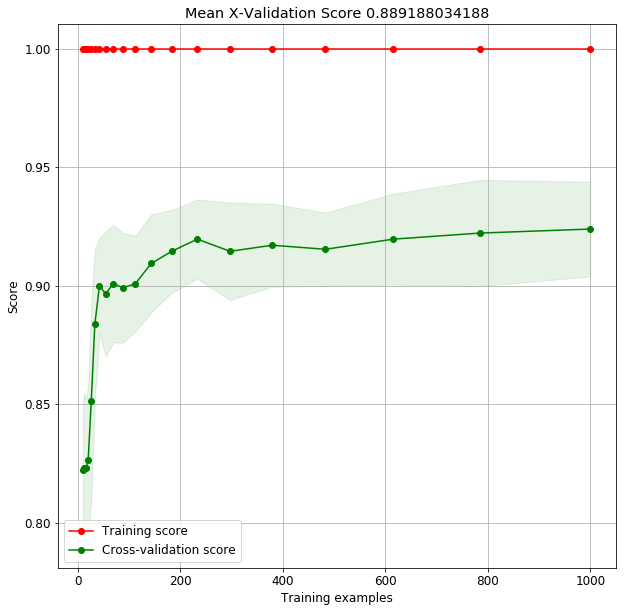

In [42]:
# Try a random forest classifier


# kwargs = {'min_samples_split': 3, 'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 10}
# estimator = RandomForestClassifier(**kwargs)
kwargs = {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 10}
estimator = KNeighborsClassifier(**kwargs)
cv = StratifiedShuffleSplit()
train_sizes = map(int, np.logspace(1, 3, 20))
train_sizes, train_scores, test_scores = learning_curve(estimator, X_total, y_total,
                                                        cv=cv, train_sizes=train_sizes)

fig, ax = plt.subplots(figsize=(10,10))
plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.title('Mean X-Validation Score {}'.format(np.mean(test_scores_mean)))

plt.legend(loc="best")
plt.savefig('RF_Classifier_learning_curve.pdf')

plt.show()



In [95]:
# tune model parameters for knn

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
for train_index, test_index in sss.split(X_total, y_total):
    X_train, X_test = X_total[train_index], X_total[test_index]
    y_train, y_test = y_total[train_index], y_total[test_index]
    W_train, W_test = weights[train_index], weights[test_index]
    
# Set the parameters by cross-validation
tuned_parameters = [{'n_neighbors': [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,30,40,50], 
                     'leaf_size': [5,6,7,8,9,10,20,30,40,50,100],
                     "weights": ['uniform', 'distance']}]

scores = ['precision']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=sss,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 5}
()
Grid scores on development set:
()
0.867 (+/-0.000) for {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 5}
0.867 (+/-0.000) for {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 5}
0.892 (+/-0.000) for {'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 5}
0.867 (+/-0.000) for {'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 5}
0.856 (+/-0.000) for {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 5}
0.856 (+/-0.000) for {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 5}
0.932 (+/-0.000) for {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 5}
0.873 (+/-0.000) for {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 5}
0.911 (+/-0.000) for {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 5}
0.891 (+/-0.000) for {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 5}
0.911 (+/-0.000) for {'n_nei

In [23]:
# # tune model parameters
# from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
# for train_index, test_index in sss.split(X_total, y_total):
#     X_train, X_test = X_total[train_index], X_total[test_index]
#     y_train, y_test = y_total[train_index], y_total[test_index]
#     W_train, W_test = weights[train_index], weights[test_index]
    
# # Set the parameters by cross-validation
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# scores = ['precision', 'recall']

# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5,
#                        scoring='%s_macro' % score, fit_params={"sample_weight": W_train})
#     clf.fit(X_train, y_train)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
#     print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred))
#     print()

In [24]:
# # Set the parameters by cross-validation
# tuned_parameters = [{'n_estimators': [10, 50, 100], 
#                      'max_depth': [3, 5, 10, None],
#                      'min_samples_split': [2, 3, 10],
#                      'min_samples_leaf': [1, 5, 10, 50, 100]}]

# scores = ['precision']

# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
#                        scoring='%s_macro' % score)
#     clf.fit(X_train, y_train)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
#     print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred))
#     print()

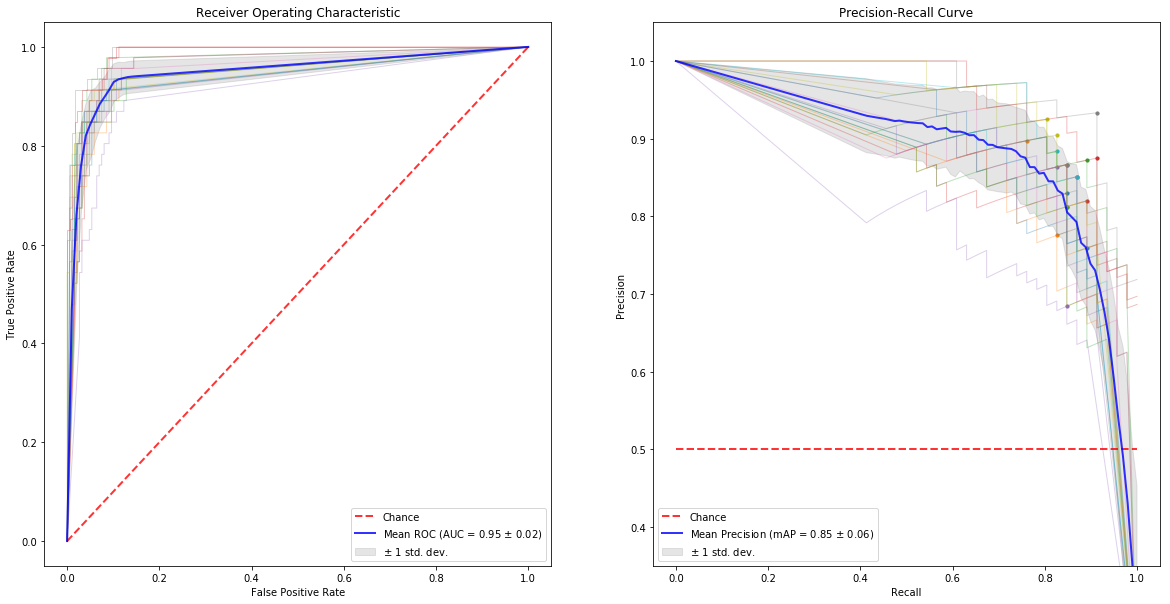

In [13]:
from sklearn.metrics import confusion_matrix
fpp_maxs = []
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2)
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(20,10))
test_no = 0
tprs = []
aucs = []
precisions = []
mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(1, 0, 100)
average_precisions = []
average_thresholds = []
f1_scores = []
for train_index, test_index in sss.split(X_total, y_total):
        
    X_train, X_test = X_total[train_index], X_total[test_index]
    y_train, y_test = y_total[train_index], y_total[test_index]
    W_train, W_test = W_total[train_index], W_total[test_index]
    
    # RANDOM FOREST
#     kwargs = {'min_samples_split': 3, 'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 10,
#               'class_weight':"balanced"}
#     clf = RandomForestClassifier(**kwargs)
    
    # SVM
#     kwargs = {'kernel': 'rbf', 'C': 100, 'gamma': 0.001, "probability": True}
#     clf = svm.SVC(**kwargs)

    #K-NN
    kwargs = {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 5}
    clf = KNeighborsClassifier(**kwargs)

    clf.fit(X_train, y_train)#, sample_weight=W_train)
#     y_pred = clf.predict(X_test)
#     tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# #     print tn, fp, fn, tp
    
#     false_positives = np.logical_and(y_test != y_pred, y_pred == 1)
#     false_negatives = np.logical_and(y_test != y_pred, y_pred == 0)
#     true_positives = np.logical_and(y_test == y_pred, y_pred == 1)
#     true_negatives = np.logical_and(y_test == y_pred, y_pred == 0)
# #     obj_ratios = X_test[false_positives]
#     obj_ratios = X_test
    
#     pred_probs = np.array([clf.predict_proba(rat.reshape(1, -1))[0][1] for rat in obj_ratios])

#     ppfp = np.array([clf.predict_proba(rat.reshape(1, -1))[0][1] for rat in X_test[false_positives]])
#     ppfn = np.array([clf.predict_proba(rat.reshape(1, -1))[0][1] for rat in X_test[false_negatives]])
#     pptp = np.array([clf.predict_proba(rat.reshape(1, -1))[0][1] for rat in X_test[true_positives]])
#     pptn = np.array([clf.predict_proba(rat.reshape(1, -1))[0][1] for rat in X_test[true_negatives]])
    
#     plt.hist([ppfp, ppfn, pptp, pptn],stacked=True, bins=21, label=['FP', 'FN', 'TP', 'TN'], 
#              color=['r', 'y', 'g', 'b'])
#     plt.legend()
#     plt.ylim([0, 20])
#     plt.title('{} positives returned ({} injected)'.format(len(pred_probs[pred_probs > min_prob]),
#                                                            len(y_test[y_test == 1])))
#     plt.axvline(x=min_prob, c='r', ls='--')
#     plt.show()
    
    y_pred = clf.predict_proba(X_test)[:,1]
    average_precisions.append(average_precision_score(y_test, y_pred))
#     precisions.append(average_precision)
    precision, recall, prthresholds = precision_recall_curve(y_test, y_pred)
#     auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    f1_score = 2 * (precision * recall) / (precision + recall)
    idx_threshold = np.argmax(f1_score)
    average_thresholds.append(prthresholds[idx_threshold])
    f1_scores.append(max(f1_score))
    
    tprs.append(interpolate.interp1d(fpr, tpr)(mean_fpr))
    precisions.append(interpolate.interp1d(recall, precision, assume_sorted=False)(mean_recall))
    tprs[-1][0] = 0.0
#     precisions[-1][0] = 1.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
#     ax.plot(fpr, tpr, label='Test {}, auc {:.2f}'.format(test_no, roc_auc), lw=1, alpha=0.3)
    ax.plot(fpr, tpr, lw=1, alpha=0.3)
    ax1.plot(recall, precision, lw=1, alpha=0.3)
    ax1.scatter(recall[idx_threshold], precision[idx_threshold], s=10)
    test_no += 1
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

ax1.plot([0, 1], [0.5, 0.5], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

mean_precision = np.mean(precisions, axis=0)
# mean_precision[-1] = 0.0
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

meanap = np.mean(average_precisions)
stdevap = np.std(average_precisions)
ax.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
ax1.plot(mean_recall, mean_precision, color='b', lw=2, alpha=.8,
         label=r'Mean Precision (mAP = %0.2f $\pm$ %0.2f)' % (meanap, stdevap))

std_precision = np.std(precisions, axis=0)
prec_upper = np.minimum(mean_precision + std_precision, 1)
prec_lower = np.maximum(mean_precision - std_precision, 0)

ax1.fill_between(mean_recall, prec_lower, prec_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')


ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([0.35, 1.05])
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
ax1.legend(loc='lower left')
# ax.legend()
plt.savefig('RF_ROC.pdf')
plt.show()
    
#     try:
#         max_idx = np.argmax(pred_probs)
#     except ValueError:
# #         print 'No False positives!'
# #         print
#         continue
    
# #     print 'Highest false positive probability: {0:.2f}'.format(max(pred_probs))
# #     fpp_maxs.append(max(pred_probs))
#     print pred_probs[pred_probs > min_prob]
    
#     fp_objs = []
#     for row in X_test[false_positives]:
#         idx = np.argwhere(row == X_total)[0][0]
#         obj_id = int(all_data[idx][0])
#         for field in fields.values():
#             if obj_id in field.object_list:
#                 fp_objs.append(field[obj_id])
                
#     print fp_objs[max_idx]
#     print
# print 'mean highest FP prob:', np.mean(fpp_maxs)
#     print tn, fp, fn, tp
#     print 'FPR: {0:.2f}%'.format(float(fp) / (float(fp + tn))*100)
#     print 'FNR: {0:.2f}%'.format(float(fn) / (float(fn + tp))*100)

In [14]:
print 'Mean Threshold {} ± {}'.format(np.mean(average_thresholds), np.std(average_thresholds))
print 'Mean F1 Score {} ± {}'.format(np.mean(f1_scores), np.std(f1_scores))

Mean Threshold 0.473021747577 ± 0.11041876829
Mean F1 Score 0.8484542768 ± 0.0336283434625


In [24]:
min_prob = 0.5

tns, fps, fns, tps = [], [], [], []
for train_index, test_index in sss.split(X_total, y_total):
        
    X_train, X_test = X_total[train_index], X_total[test_index]
    y_train, y_test = y_total[train_index], y_total[test_index]
    W_train, W_test = W_total[train_index], W_total[test_index]
#     kwargs = {'min_samples_split': 3, 'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 10,
#               'class_weight':"balanced"}
#     clf = RandomForestClassifier(**kwargs)
#     kwargs = {'kernel': 'rbf', 'C': 100, 'gamma': 0.001, "probability": True}
#     clf = svm.SVC(**kwargs)

    kwargs = {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 5}
    clf = KNeighborsClassifier(**kwargs)
    clf.fit(X_train, y_train)#, sample_weight=W_train)
    
    y_pred = clf.predict_proba(X_test)[:,1]
    y_pred_class = (y_pred > min_prob).astype(int) # use threshold
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()
    fps.append(float(fp))
    fns.append(float(fn))
    tps.append(float(tp))
    tns.append(float(tn))
tns = np.array(tns)
fns = np.array(fns)
tps = np.array(tps)
tns = np.array(tns)

print 'Threshold: ', min_prob
print 'Mean FPR:', np.mean(fps / (fps + tns)) * 100
print 'Mean TNR:', np.mean(tns / (tns + fps)) * 100
print 'Mean FNR:', np.mean(fns / (fns + tps)) * 100
print 'Mean TPR:', np.mean(tps / (tps + fns)) * 100
print 'Mean FDR:', np.mean(fps / (fps + tps)) * 100

Threshold:  0.5
Mean FPR: 4.919786096256685
Mean TNR: 95.08021390374333
Mean FNR: 20.869565217391305
Mean TPR: 79.13043478260869
Mean FDR: 19.9728011978323


In [25]:
print np.matrix([[np.mean(tps), np.mean(fps)], [np.mean(fns), np.mean(tns)]]) * 30

[[1092.  276.]
 [ 288. 5334.]]


In [26]:
# diff_pr_re = mean_precision - mean_recall
# idx_threshold_max = np.argmax(diff_pr_re)
# threshold_to_use = prthresholds[idx_threshold_max]
# roc_thresh_idx = np.argmin(thresholds - threshold_to_use)
# print 'Threshold: ', threshold_to_use
# print 'Mean FPR:', mean_fpr[roc_thresh_idx] * 100
# print 'Mean TNR:', (1 - mean_fpr[roc_thresh_idx]) * 100
# print 'Mean FNR:', (1 - mean_tpr[roc_thresh_idx]) * 100
# print 'Mean TPR:', mean_tpr[roc_thresh_idx] * 100
# print 'Mean FDR:', (1 - mean_precision[idx_threshold_max]) * 100

In [27]:
# Doesn't work due to interpolation step
# diff_tpr_fpr = mean_tpr - mean_fpr
# idx_threshold_max = np.argmax(diff_tpr_fpr)
# threshold_to_use = thresholds[idx_threshold_max]
# prec_thresh_idx = np.argmin(prthresholds - threshold_to_use)
# print 'Threshold: ', threshold_to_use
# print 'Mean FPR:', mean_fpr[idx_threshold_max] * 100
# print 'Mean TNR:', (1 - mean_fpr[idx_threshold_max]) * 100
# print 'Mean FNR:', (1 - mean_tpr[idx_threshold_max]) * 100
# print 'Mean TPR:', mean_tpr[idx_threshold_max] * 100
# print 'Mean FDR:', (1 - mean_precision[prec_thresh_idx]) * 100

In [28]:
# def calculate_tangent_length(x0, y0, gradient, roc_or_prec='prec'):
#     c = y0 - gradient * x0
#     if roc_or_prec == 'prec':
#         # points at (1, y1), (x1, 1)
#         if x0 == 1.0 or y0 == 1.0 or gradient > 0:
#             return np.inf
#         y1 = gradient + c
#         x1 = (1. - c) / gradient
#         tangent_length = np.sqrt((1. - y1)**2 + (1 - x1)**2)
#     elif roc_or_prec == 'roc':
#         # points at (0, y1), (x1, 1)
#         if x0 == 0.0 or y0 == 1.0 or gradient < 0:
#             return np.inf
#         y1 = c
#         x1 = (1. - c) / gradient
#         tangent_length = np.sqrt((1. - y1)**2 + (x1)**2)
#     else:
#         return None
#     if (0 <= y1 <= 1) and (0 <= x1 <= 1):
#         return tangent_length
#     else:
#         return np.inf

In [29]:
# # optimise thresholds with tangents
# prec_gradients = np.gradient(mean_precision, mean_recall)
# roc_gradients = np.gradient(mean_tpr, mean_fpr)
# gradients = prec_gradients
# tangent_lengths = []
# for i in range(len(mean_recall)):
#     tangent_lengths.append(calculate_tangent_length(mean_recall[i], mean_precision[i], gradients[i], 'prec'))
# #     tangent_lengths.append(calculate_tangent_length(mean_fpr[i], mean_tpr[i], gradients[i], 'roc'))
# best_threshold_idx = np.argmin(tangent_lengths)
# # best_threshold_idx = 10
# print prthresholds[best_threshold_idx]
# # print thresholds[best_threshold_idx]

# intercept = mean_precision[best_threshold_idx] - gradients[best_threshold_idx] * mean_recall[best_threshold_idx]
# # intercept = mean_tpr[best_threshold_idx] - gradients[best_threshold_idx] * mean_fpr[best_threshold_idx]

# f = lambda x: gradients[best_threshold_idx] * x + intercept
# fminus1 = lambda x: (x - intercept) / gradients[best_threshold_idx]

# plt.plot(mean_recall, mean_precision)
# plt.plot(mean_recall, f(mean_recall))
# plt.scatter(1, f(1), s=100, c='g')
# plt.scatter(fminus1(1), 1, s=100, c='b')
# plt.scatter(mean_recall[best_threshold_idx], mean_precision[best_threshold_idx], s=100, c='r')
# # plt.plot(mean_fpr, mean_tpr)
# # plt.plot(mean_fpr, f(mean_fpr))
# # plt.scatter(mean_fpr[best_threshold_idx], mean_tpr[best_threshold_idx], s=100, c='r')
# # plt.scatter(0, f(0), s=100, c='g')
# # plt.scatter(fminus1(1), 1, s=100, c='b')
# print (1, f(1))
# print (fminus1(1), 1)
# # print tangent_lengths[best_threshold_idx]
# plt.axvline(x=1, c='gray', lw=1, ls='--')
# plt.axvline(x=0, c='gray', lw=1, ls='--')
# plt.axhline(y=1, c='gray', lw=1, ls='--')
# plt.ylim([0.35, 1.05])

# print 'Precision: {}, Recall: {}, Threshold: {}'.format(mean_precision[best_threshold_idx], 
#                                                         mean_recall[best_threshold_idx],
#                                                         prthresholds[best_threshold_idx])

# plt.show()

In [30]:
# distance_through_array = float(best_threshold_idx) / len(tangent_lengths)
# print distance_through_array
# threshtimates = []
# for t in prthreshs:
#     idx = int((1 - distance_through_array) * len(t))
#     threshtimates.append(t[idx])
# print 'Threshold: {} ± {}'.format(np.mean(threshtimates), np.std(threshtimates))

In [31]:
# col = np.append(np.array([0]), prthresholds)
# plt.scatter(recall, precision, c=col)
# plt.colorbar()
# plt.scatter(mean_recall[best_threshold_idx], mean_precision[best_threshold_idx], s=100, c='r')
# plt.show()

# col = thresholds
# plt.scatter(fpr, tpr, c=col)
# plt.colorbar()
# plt.show()

In [32]:
# fig, ax = plt.subplots()
# for i in range(len(prthreshs)):
#     ax.scatter(prthreshs[i], np.linspace(i, i, len(prthreshs[i])))
    
# # prthreshs = np.array([np.array(prthresh) for prthresh in prthreshs])

In [33]:
# print prthresholds
# print
# print recall
# print
# print precision

In [34]:
# print mean_precision
# print 
# print mean_recall

In [44]:
# caluclate number of each class
P = len(y_total[y_total == 1.0])
N = len(y_total[y_total == 0.0])
print P, N, P+N

TP = int(P * mean_tpr[idx_threshold_max])
TN = int(N * (1 - mean_fpr[idx_threshold_max]))

FP = N - TN
FN = P - FP

print np.matrix([[TP, FP], [FN, TN]])

print float(FP) / float(FP + TP)

232 933 1165
[[215  85]
 [147 848]]
0.283333333333


Using 304 of 1165 indexes total
[[2.68064177 2.07345305 1.9506641 ]
 [2.19718258 1.88488708 2.28333813]
 [2.03750425 1.7763825  2.04088672]
 [2.32641003 1.74647733 1.78711264]]


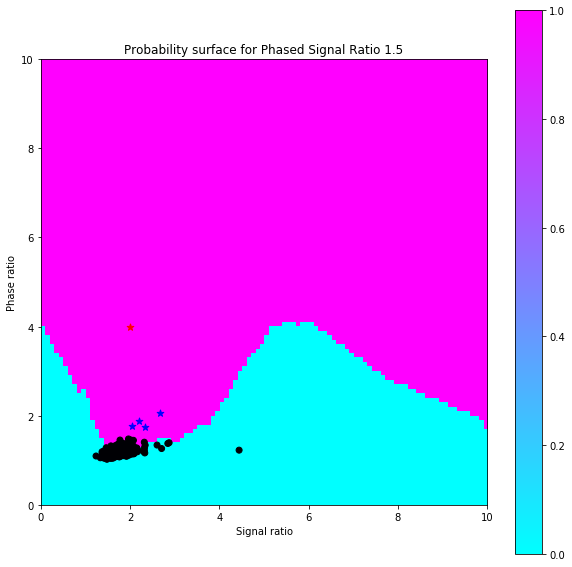

In [60]:
zz = 0.5
xx = np.linspace(1, 10, 100)
yy = np.linspace(1, 10, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel(),np.ones(10000)+zz]
probas = clf.predict_proba(Xfull)

a, b, c = np.array([r[0] for r in X_total]), np.array([r[1] for r in X_total]), np.array([r[2] for r in X_total])

idx_good = np.nonzero((c < 1.1*(1+zz)) & (c > 0.9*(1+zz)))

old_len = len(c)
a = a[idx_good]
b = b[idx_good]
c = c[idx_good]

print 'Using {} of {} indexes total'.format(len(c), old_len)


colors = y_total[idx_good]

fig, ax = plt.subplots(figsize=(10,10))
plot_data = np.ma.masked_where(probas[:, 1].reshape(100,100) >= 0.5, probas[:, 1].reshape(100,100)).mask.astype(int)
# plot_data = probas[:, 1].reshape(100,100)
imshow_handle = ax.imshow(plot_data, extent=[0,10,0,10], origin='lower', cmap='cool')
ax.scatter(a,b, c=colors, cmap='magma')
ax.set_xlim([0,10])
ax.set_ylim([0,10])
plt.colorbar(imshow_handle)
ax.set_xlabel('Signal ratio')
ax.set_ylabel('Phase ratio')
ax.set_title('Probability surface for Phased Signal Ratio {}'.format(1+zz))


# banded yellow region, show k-nn for a point in this region.

X_point = [2.0, 4.0, 1.5]
distances, idxs = clf.kneighbors([X_point])
distances = distances[0]
idxs = idxs[0]

knns = X_train[idxs]
print knns
plt.scatter(X_point[0], X_point[1], c='r', s=50, marker='*')
knn_xs = [p[0] for p in knns]
knn_ys = [p[1] for p in knns]

plt.scatter(knn_xs, knn_ys, c='b', s=50, marker='*')

plt.show()


1

In [ ]:
# #display a tree from RF
# estimator = clf.estimators_[0]
# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = ['Signal Ratio', 'Phase Ratio', 'Phase Signal Ratio'],
#                 class_names = ['Not Signal', 'Signal'],
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

In [140]:
# obj = fields['NG0304-1115'][6332]
# t = obj.timeseries_binned
# f = obj.flux_binned
# p = obj.periods[0]
# phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
# # binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5))
# ax1.scatter(t-t[0], f, s=0.1)
# ax1.set_title('Data'.format(p))
# ax2.scatter(phase_app, data_app, s=0.1)
# ax2.scatter(binned_phase_app, binned_data_app, s=5, c='r')
# ax2.axvline(x=0, lw=0.1, c='k', ls='--')
# ax2.axvline(x=1, lw=0.1, c='k', ls='--')
# ax2.set_title('Data phase folded on {} day period'.format(p))
# fig.tight_layout()
# plt.show()

In [163]:
false_positives = np.logical_and(y_test != y_pred, y_pred == 1)
false_negatives = np.logical_and(y_test != y_pred, y_pred == 0)
true_positives = np.logical_and(y_test == y_pred, y_pred == 1)
true_negatives = np.logical_and(y_test == y_pred, y_pred == 0)
obj_ratios_fp = X_test[false_positives]
obj_ratios_fn = X_test[false_negatives]

In [164]:
pred_probs_fp = [clf.predict_proba(rat.reshape(1, -1))[0][1] for rat in obj_ratios_fp]
print ', '.join(map(str, sorted(pred_probs_fp)))
pred_probs_fn = [clf.predict_proba(rat.reshape(1, -1))[0][1] for rat in obj_ratios_fn]
print ', '.join(map(str, sorted(pred_probs_fn)))

0.5379803430735027, 0.5384286660327813, 0.555174951925263, 0.568242171395931, 0.6897096546452315, 0.8256070539402455, 0.93936660949171
0.046281042219115165, 0.04814222722487184, 0.12790202519769783, 0.20237237387728635, 0.20978681838485905, 0.23434424145262853, 0.32264365956222446, 0.3657256487133395, 0.39321173051409913, 0.42720266690869424, 0.4566661358636275, 0.4725349247884437


In [165]:
fp_objs = []
for row in X_test[false_positives]:
    idx = np.argwhere(row == X_total)[0][0]
    obj_id = int(all_data[idx][0])
    for field in fields.values():
        if obj_id in field.object_list:
            fp_objs.append(field[obj_id])

In [166]:
fn_objs = []
for row in X_test[false_negatives]:
    idx = np.argwhere(row == X_total)[0][0]
    obj_id = int(all_data[idx][0])
    for field in fields.values():
        if obj_id in field.object_list:
            fn_objs.append(field[obj_id])

**** FALSE POSITIVES ****
*******
NGTS Object NG0304-1115_16290 (CYCLE1807)
[2.27581325 1.38806429 2.45776224]
[[0.44482505 0.55517495]]


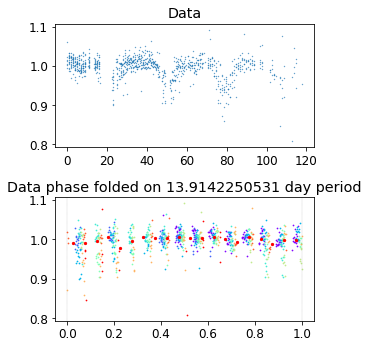

*******
NGTS Object NG2142+0826_26591 (CYCLE1807)
[3.81843041 1.55971565 2.71374888]
[[0.17439295 0.82560705]]


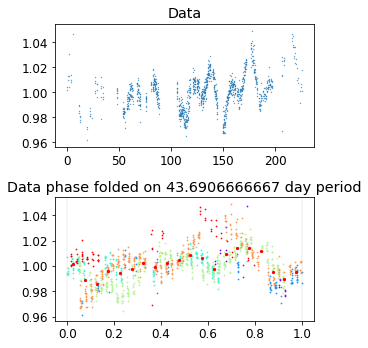

*******
NGTS Object NG2142+0826_87 (CYCLE1807)
[2.90375646 1.41696014 2.19458067]
[[0.46157133 0.53842867]]


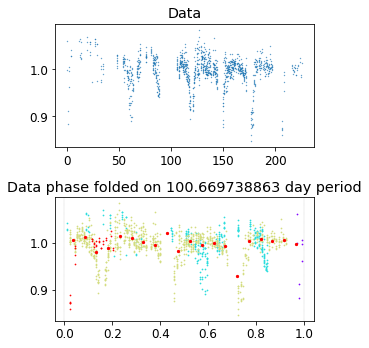

*******
NGTS Object NG0304-1115_16201 (CYCLE1807)
[2.16210016 1.43287638 2.6044916 ]
[[0.31029035 0.68970965]]


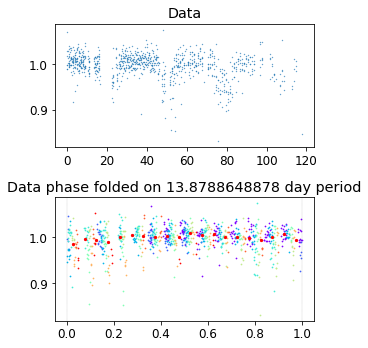

*******
NGTS Object NG1416-2518_17357 (CYCLE1807)
[4.78830207 1.7200127  7.16261265]
[[0.06063339 0.93936661]]


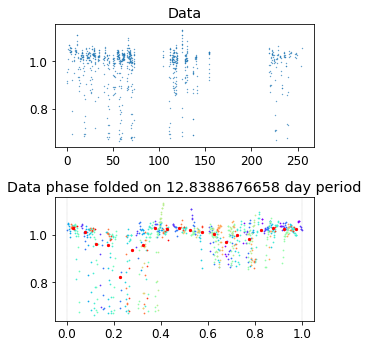

*******
NGTS Object NG2142+0826_15874 (CYCLE1807)
[1.55866817 1.39936296 6.06076544]
[[0.43175783 0.56824217]]


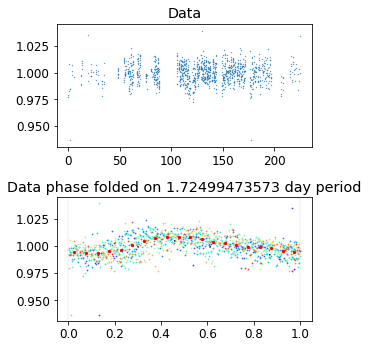

*******
NGTS Object NG2142+0826_17163 (CYCLE1807)
[2.46860975 1.61094351 2.09632846]
[[0.46201966 0.53798034]]


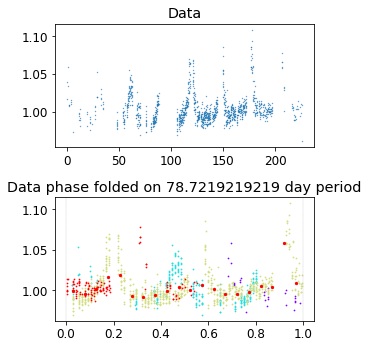

In [167]:
print '**** FALSE POSITIVES ****'
for obj, rat in zip(fp_objs, obj_ratios_fp):
    print '*******'
    print obj
    print rat
    print clf.predict_proba(rat.reshape(1, -1))
    t = obj.timeseries_binned
    f = obj.flux_binned
    p = obj.periods[0]
    phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
    binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
    ndata = len(phase_app)
    idx = [i for i in range(1,ndata) if phase_app[i]<phase_app[i-1] ]
    idx.append(ndata-1)
    nidx = len(idx)
    colours = mpl.cm.rainbow(np.r_[0:1:nidx*1j])
    phases, fs = [], []
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5))
    ax1.scatter(t-t[0], f, s=0.1)
    ax1.set_title('Data'.format(p))
    j=0
    for k,i in enumerate(idx):
        phases.append( np.array(phase_app[j:i]) )
        fs.append( np.array(f[j:i]) )
        ax2.scatter(phases[k], fs[k], marker='o', s=0.5, c=colours[k])
        j=i
    ax2.scatter(binned_phase_app, binned_data_app, s=5, c='r')
    ax2.axvline(x=0, lw=0.1, c='k', ls='--')
    ax2.axvline(x=1, lw=0.1, c='k', ls='--')
    ax2.set_title('Data phase folded on {} day period'.format(p))
    fig.tight_layout()
    plt.show()

**** FALSE NEGATIVES ****
*******
NGTS Object NG2142+0826_29600 (CYCLE1807)
[2.13658659 1.16839513 2.39956341]
[[0.87209797 0.12790203]]


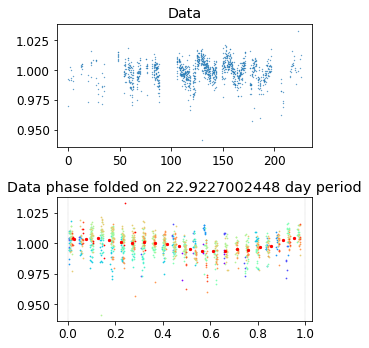

*******
NGTS Object NG2142+0826_6270 (CYCLE1807)
[2.09689337 1.50699493 2.05780287]
[[0.67735634 0.32264366]]


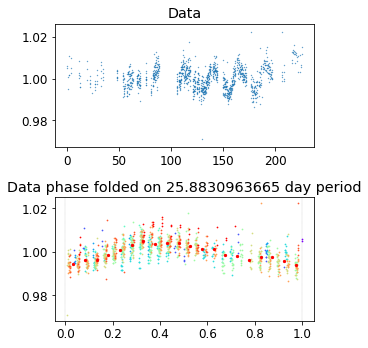

*******
NGTS Object NG2142+0826_1039 (CYCLE1807)
[2.16335342 1.30103727 3.75572089]
[[0.60678827 0.39321173]]


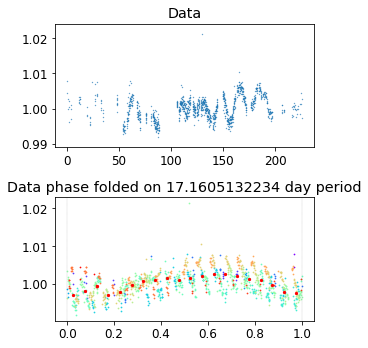

*******
NGTS Object NG0304-1115_13068 (CYCLE1807)
[1.76870151 1.41640666 2.00919632]
[[0.79762763 0.20237237]]


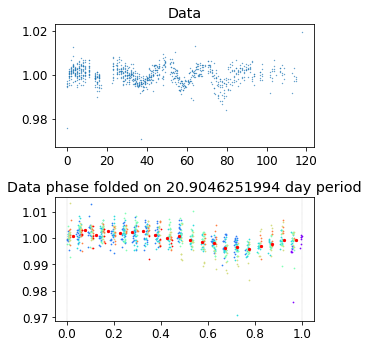

*******
NGTS Object NG0304-1115_8379 (CYCLE1807)
[1.80312315 1.31590897 2.16131337]
[[0.95371896 0.04628104]]


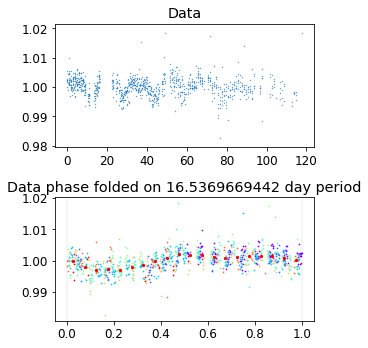

*******
NGTS Object NG2142+0826_31566 (CYCLE1807)
[2.15449586 1.60699387 2.16276363]
[[0.52746508 0.47253492]]


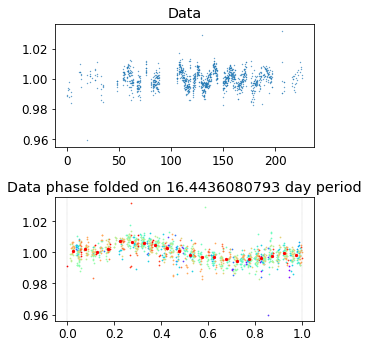

*******
NGTS Object NG2142+0826_4898 (CYCLE1807)
[1.59707786 1.30999273 2.30032742]
[[0.95185777 0.04814223]]


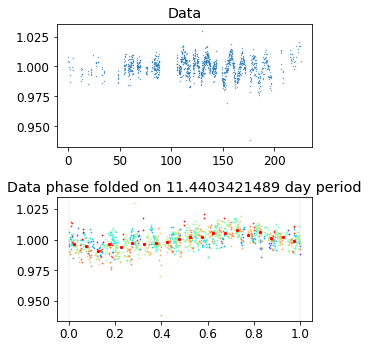

*******
NGTS Object NG0304-1115_18918 (CYCLE1807)
[2.41215786 1.42289305 2.02168117]
[[0.57279733 0.42720267]]


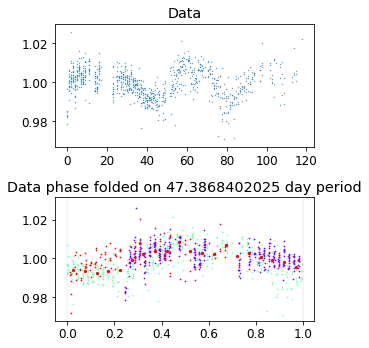

*******
NGTS Object NG2142+0826_17299 (CYCLE1807)
[2.03907086 1.42483141 2.35319584]
[[0.63427435 0.36572565]]


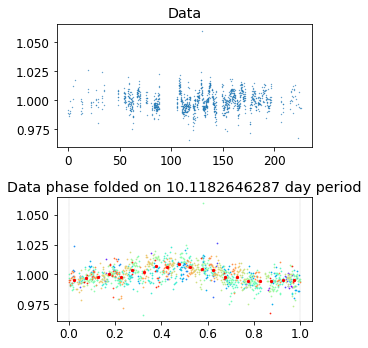

*******
NGTS Object NG2142+0826_11029 (CYCLE1807)
[2.68064177 2.07345305 1.9506641 ]
[[0.54333386 0.45666614]]


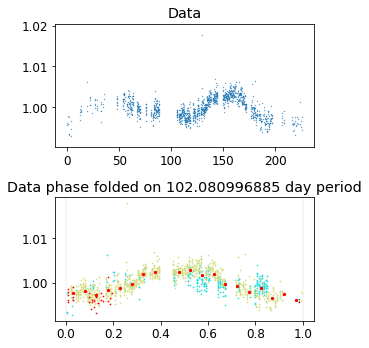

*******
NGTS Object NG2142+0826_12410 (CYCLE1807)
[ 1.65313044  1.20102724 10.30558355]
[[0.79021318 0.20978682]]


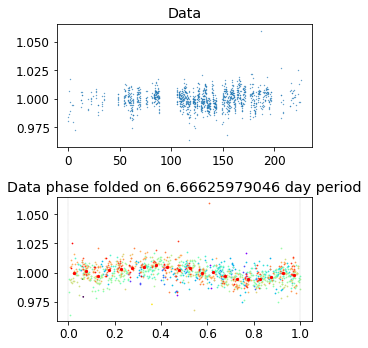

*******
NGTS Object NG2142+0826_14209 (CYCLE1807)
[1.81579787 1.28917832 3.40156914]
[[0.76565576 0.23434424]]


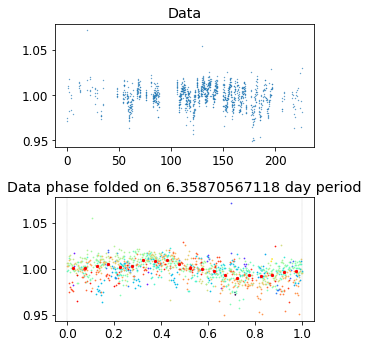

In [169]:
print '**** FALSE NEGATIVES ****'
for obj, rat in zip(fn_objs, obj_ratios_fn):
    print '*******'
    print obj
    print rat
    print clf.predict_proba(rat.reshape(1, -1))
    t = obj.timeseries_binned
    f = obj.flux_binned
    p = obj.periods[0]
    phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
    binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
    ndata = len(phase_app)
    idx = [i for i in range(1,ndata) if phase_app[i]<phase_app[i-1] ]
    idx.append(ndata-1)
    nidx = len(idx)
    colours = mpl.cm.rainbow(np.r_[0:1:nidx*1j])
    phases, fs = [], []
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5))
    ax1.scatter(t-t[0], f, s=0.1)
    ax1.set_title('Data'.format(p))
    j=0
    for k,i in enumerate(idx):
        phases.append( np.array(phase_app[j:i]) )
        fs.append( np.array(f[j:i]) )
        ax2.scatter(phases[k], fs[k], marker='o', s=0.5, c=colours[k])
        j=i
    ax2.scatter(binned_phase_app, binned_data_app, s=5, c='r')
    ax2.axvline(x=0, lw=0.1, c='k', ls='--')
    ax2.axvline(x=1, lw=0.1, c='k', ls='--')
    ax2.set_title('Data phase folded on {} day period'.format(p))
    fig.tight_layout()
    plt.show()

In [11]:
CLASSIFIER_LOCATION = '/home/jtb34/GitHub/GACF/NGTS/GACF_utils/rf_classifier.joblib'
clf =  load(CLASSIFIER_LOCATION)

In [20]:
int(clf.predict_proba(np.array((10,10,10)).reshape(1, -1))[0][1] > 0.99)

0

In [21]:
# test object and field methods work ok

In [ ]:
reload(NGTS_Field)
fieldname = 'NG2142+0826'
objs = [6144, 19463,18546, 6270,24736]
field = NGTS_Field.return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', 
                                               include_empty_objects=True, silent=True, obj_ids=objs)
fits_file, _, _ = find_fits_file(os.path.join(ROOT_DIR, fieldname))
field.load_from_fits(fits_file, obj_ids=objs, method='fitsio', sparse_ids=True)
print 'Field {} loaded'.format(field)

matched 9228 of 9610 files. Loaded 5 objects


In [ ]:
# new_moon_epoch = field.get_new_moon_epoch()
new_moon_epoch = 944.9751975389386

In [ ]:
field.get_ratio_estimator()

In [9]:
for obj in field:
    print obj.check_signal_significance_estimator(field.ratio_estimator, min_prob=0.7, epoch=new_moon_epoch)

NameError: global name 'new_moon_epoch' is not defined

In [9]:
for obj in field:
    print '*******'
    print obj
    rat = obj.calculate_signal_strength_ratios(epoch=new_moon_epoch)
    print rat
    print field.ratio_estimator.predict_proba(np.array(rat).reshape(1,-1))
    t = obj.timeseries_binned
    f = obj.flux_binned
    p = obj.periods[0]
    phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
    binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
    ndata = len(phase_app)
    idx = [i for i in range(1,ndata) if phase_app[i]<phase_app[i-1] ]
    idx.append(ndata-1)
    nidx = len(idx)
    colours = mpl.cm.rainbow(np.r_[0:1:nidx*1j])
    phases, fs = [], []
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5))
    ax1.scatter(t-t[0], f, s=0.1)
    ax1.set_title('Data'.format(p))
    j=0
    for k,i in enumerate(idx):
        phases.append( np.array(phase_app[j:i]) )
        fs.append( np.array(f[j:i]) )
        ax2.scatter(phases[k], fs[k], marker='o', s=0.5, c=colours[k])
        j=i
    ax2.scatter(binned_phase_app, binned_data_app, s=5, c='r')
    ax2.axvline(x=0, lw=0.1, c='k', ls='--')
    ax2.axvline(x=1, lw=0.1, c='k', ls='--')
    ax2.set_title('Data phase folded on {} day period'.format(p))
    fig.tight_layout()
    plt.show()

*******
NGTS Object NG2142+0826_6144 (CYCLE1807)


NameError: global name 't' is not defined